# 5. Insights
***

To recap, so far we have read in our data, cleaned our data, engineered new features, and iteratively assessed our model scores. We also took our strongest models, ensembled them, and checked performance against a simpler, non NLP based model.

***
# <span style="color:blue">**Differentiating Features**</span>

Now that we have a model selected, it's time to understand what is really driving differentiation between a dad joke, and a normal joke. In order to do this, we'll take our winning model and assess some of it's properties. In this section, we're interested in digging into the following questions:

 - *What words are most closely associated with a normal joke? A Dad joke?*
 - *What do the jokes look like when our model is confident and wrong?*
 - *What does our confusion matrix, and ROC curve tell us about our model?*
 
For this section, for ease of interpretability, we'll move forward with our top performing, individual Logistic Regression model.

In [1491]:
#Walk through Pipe, Param Grid, GridSearch process
pipe_lr_cvec_fulltext = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('lr' , LogisticRegression())
])

pipe_params_lr_cvec_fulltext = {
    'cvec__max_features': [1200,1500],
    'cvec__max_df': [.3,.4,.5,.65,.75,.85],
    'cvec__ngram_range': [(1,1)],
    'lr__penalty':['l2','l1'],
    'lr__C':[.01,0.1, 1]
}

gs_lr_cvec_fulltext = GridSearchCV(pipe_lr_cvec_fulltext, 
                  pipe_params_lr_cvec_fulltext, 
                  cv=3)


In [1493]:
#Fit model and store best model
gs_lr_cvec_fulltext.fit(X_train_fulltext,y_train)
lr_best_model = gs_lr_cvec_fulltext.best_estimator_

C:\Users\Owen\Anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Question: What words are most closely associated with DadJokes?**

We can use the coefficients from our model to answer this question. Our coefficients will relate back to our binary target in the following way: **particularly negative coefficients will be more predictive of our negative outcome (r/Jokes); particularly positive coefficients will be more predictive of our positive outcome (r/DadJokes)**. As we dig in, we realize that more negative coeffcients are generally associated with offensive topics (religion, race); more positive coefficients are more closely associated with familial/simple contextual terms (daughter/father; walking/eating). We can plot these to better chart these relationships.

In [512]:
#Grab resulting coefficients and toss into a data frame
coef_df = pd.DataFrame(lr_best_model.steps[1][1].coef_).T

In [513]:
coef_df.columns = ['coefficient']
coef_df['word'] = lr_best_model.steps[0][1].get_feature_names()
coef_df = coef_df.sort_values('coefficient')

In [514]:
coef_df.head(8)

,coefficient,word
532,-0.439292,girl
684,-0.423602,jesus
1448,-0.412235,whats
648,-0.405302,husband
568,-0.384384,guy
1465,-0.382760,woman
800,-0.376269,man
359,-0.374950,difference


In [515]:
coef_df.tail(8)

,coefficient,word
1415,0.263037,walking
1445,0.263095,went
747,0.268991,legs
357,0.273967,died
1097,0.274189,runclejokes
314,0.299580,dad
781,0.350365,looking
277,0.357550,cool


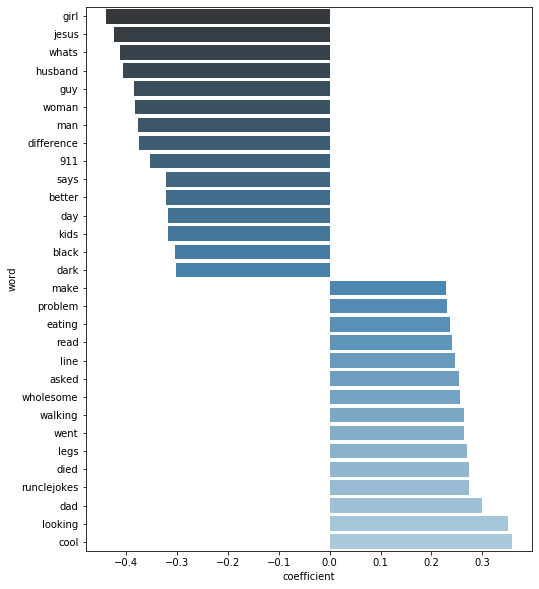

In [498]:
plt.figure(figsize=(8,10))
sns.barplot(data=joke_words, x='coefficient', y='word',orient='h',
palette=("Blues_d"));


**Question: What do the jokes look like when our model is confident and wrong?**

What does our model get REALLY wrong? Let's try to isolate for **False Positives** and **False Negatives** when our model is confident in it's classifications. This will allow us to identify any trends that we can potentially feed back into our model. We'll accomplish this by leveraging **.predict_proba()** to access observation level probabilities. We'll then connect those probabilities back to the original text through **joke_id.**

When we do this, we notice a couple of interesting things:
 - First, it looks like some r/Jokes posts closely resemble r/DadJokes post. This isn't surprising-- it's very likely that users that frequent one of these subreddits also frequent the other.
 - Comments can be vulgar, offtopic, and random on both of these subreddits. This may be one reason why a model train solely on comment data is not as effective

In [516]:
#Build a dataframe of our predict probas, and the actual classifications
X_train_fulltext_df = pd.DataFrame(X_train_fulltext)
X_train_fulltext_df['y_train'] = y_train
X_train_fulltext_probas = pd.DataFrame(lr_best_model.predict_proba(X_train_fulltext))

In [518]:
#jokeID will connect our model probabilities to our words
X_train_fulltext_probas['joke_id'] = pd.Series(X_train_fulltext.index)
X_train_fulltext_df['joke_id'] = pd.Series(X_train_fulltext.index)

In [519]:
#Merge our dataframes
X_train_fulltext_df = pd.merge(X_train_fulltext_df, X_train_fulltext_probas, left_on='joke_id',right_on='joke_id')

In [522]:
#Jokes that our algorithm confidently thought were dad jokes
list(X_train_fulltext_df.loc[(X_train_fulltext_df['y_train'] == 0) &(X_train_fulltext_df[1] > .88),'full_text'])

['my wife got onto me the other day claiming i spent too much time moistening food while cooking thinking the accusations as ridiculous i asked baste on what So You got kids yet Youre ready I bet you glazed over while she grilled you Nice to meat you have an upvote',
 'a husband was bit embarrassed and told the doctor he had trouble getting an erection a husband was a bit embarrassed and told the doctor he had trouble getting an erection with his wife and she was getting frustrated the doc checked the mans blood pressure and other vitals then after a thorough examination said he wanted to check with the wife he took her to another cubicle and asked her to disrobe then he told her to turn all the way around slowly she did as instructed he then told her to raise her arms above her head then bend over touch her toes and cough finally he said ok good you can get dressed now and i will go talk to your husband the doctor went back to the other cubicle and said to the husband well bill you ca

In [525]:
#Dad Jokes that our algorithm confidently thought were jokes
list(X_train_fulltext_df.loc[(X_train_fulltext_df['y_train'] == 1) &(X_train_fulltext_df[0] > .99),'full_text'])

['who says oh oh oh santa walking backwards  ',
 'i asked my son hey what do you call a rubber loop that you put rocks and bread into he shrugged and said he had no idea so i answered a rock and roll band  ',
 'my mattress is starting to hurt my back but i dont know if i can afford a new one i think ill just sleep on it  ',
 'son dad can you tell me what a solar eclipse is dad no sun How punny Wasnt this like the top last week Can we try and space out the reposts Its Mitsubishis attempt to compete with Tesla Well played dad Gibbous more of these space puns did he tell him SUN OF A BITCH Damn Thats dark Fine then keep your secrets My dad is an eclipse chaser and Im 100 sure hed do this if he had a son who asked him what a solar eclipse is',
 'the invention of the wheel is very wellrounded well spoken but now I am too tired Must be a bicycle The invention of the shovel was ground breaking revolutionary']

***What does our confusion matrix, and ROC curve tell us about our model?***

In [537]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#Generate our predictions with this model.
preds = lr_best_model.predict(X_test_fulltext)

#Print our accuracy score, and classification report
print(f'Accuracy: {accuracy_score(y_test, preds)}')

#Store confusion_matrix returns for reference
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


spec = tn / (tn + fp)
print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens,4)}')

Accuracy: 0.6834645669291338
Specificity: 0.3843
Sensitivity: 0.9019


**Sensitivity is very good** for our model. This means that when the model predicts that a post is from r/DadJokes, it's often the case that this is true. On the other hand, **specificity is very, very bad here**. This means that it is not very good at all at effectively telling us when a joke actually belongs to **r/Jokes**. Given what we see above, it does appear that there are a good amount of r/Jokes observations that could, from a human vantage point, be interpreted as r/DadJokes.

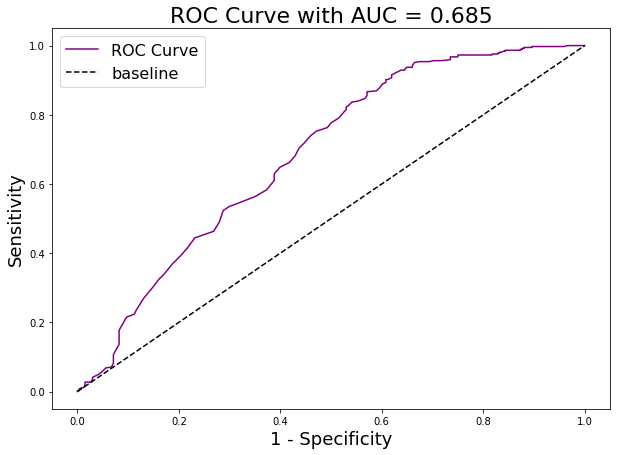

In [541]:
from sklearn.metrics import roc_auc_score
pred_proba = [i[1] for i in lr_best_model.predict_proba(X_test_fulltext)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve', c='purple')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--', c='black')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## <span style="color:Black">**Additional Analysis: Frequency**</span>

In [67]:
vec = CountVectorizer(stop_words='english').fit(X_train_joke)
bag_of_words = vec.transform(X_train_joke)
sum_words = bag_of_words.sum(axis=0)

In [68]:
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [542]:
words_freq[:15]

[('said', 197),
 ('man', 197),
 ('says', 152),
 ('im', 152),
 ('did', 131),
 ('just', 128),
 ('like', 117),
 ('dont', 108),
 ('wife', 97),
 ('know', 97),
 ('asked', 94),
 ('got', 92),
 ('say', 88),
 ('dad', 81),
 ('people', 75)]